# Assignment 09 - Generative Modeling (Total xx Points)
<span style='color:red'> Due date: 13.07.2021 23:59</span>

This week's assignment is about Generative Modeling. If anything is unclear or if you find errors, feel free to post in the forum set up in Ilias or ask in the WebEx live session, or write an email to one of us.

_You can submit incomplete assignments that don't validate_. If a test cell validates correctly, you will get the points. If test cells don't validate, you may still get at least partial points. The validation for this exercise takes a long time. You can skip the validation, since you already know from the test cells whether your code works. You don't need to validate before submitting an exercise.

## Autoencoders (17 points)
We talked about the capability of autoencoders to perform lossy data compression in the lecture. Instead of a deterministic way of doing this, like classical compression algorithms such as JPG, MPG, bzip2 do, they *learn* such a compression (if used in a clever way, they outperform all common compression algorithms, see [here](https://hackernoon.com/using-ai-to-super-compress-images-5a948cf09489)). Here, we'll compare three different styles of standard autoencoders and their compression capability on the MNIST data set.

The following code cell imports everything we'll need and also loads the MNIST data set without labels:

In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

X = np.load("/data/X.npy") / 255

testsplit = int(0.8*X.shape[0])
X_train = X[:testsplit]
X_test  = X[testsplit:]

input_dim = X_train.shape[1]
# this fixes the latent space dimension, feel free to play around with
# the values for your own experiments, but leave it at 2 for the assignment
latent_dim = 2

print(X_train.shape)

(56000, 784)


### Shallow Standard Autoencoder
Both the encoder and the decoder are fully-connected ANNs. The encoder usually works with $\text{ReLU}$ or $\text{LeakyReLU}$, the decoder usually with $\text{sigmoid}$ activation (why?). In the cell below, implement a simple shallow autoencoder with an input layer, a bottleneck layer of size $2$, and an output layer that can reconstruct an MNIST image.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 1570      
_________________________________________________________________
dense_1 (Dense)              (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


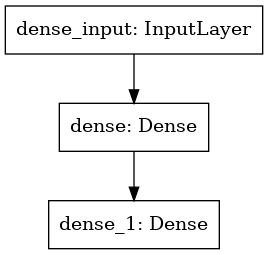

In [2]:
from tensorflow.keras.backend import clear_session

clear_session()

# this is very similar to what we've done before. First, instantiate a
# "Sequential()" model in a variable called "shallow_ae". Then, add a
# "Dense()" layer to shallow_ae with latent_dim neurons, an appropriate "input_shape"
# and activation "relu". Afterwards, add another Dense layer with an appropriate
# number of neurons to be able to construct an MNIST image and "sigmoid"
# activation.
### BEGIN SOLUTION
shallow_ae = Sequential()
shallow_ae.add(Dense(latent_dim, input_shape=(input_dim,), activation='relu'))
shallow_ae.add(Dense(X_train.shape[1], activation='sigmoid'))
### END SOLUTION

# see if your model makes sense. It should have 3922 trainable parameters
shallow_ae.summary()

plot_model(shallow_ae)

This is a very shallow model. We can extract the encoder part by extracting the first layer of the network:

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1570      
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               2352      
Total params: 2,352
Trainable params: 2,352
Non-trainable params: 0
_________________________________________________________________


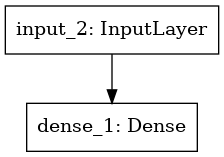

In [4]:
# create an input layer with the appropriate shape
input_img = Input(shape=(input_dim,))
input_lat = Input(shape=(latent_dim,))

# extract the first shallow_ae layer
encoder_layer = shallow_ae.layers[0]
decoder_layer = shallow_ae.layers[-1]

# make them addressable models
shallow_encoder = Model(input_img, encoder_layer(input_img))
shallow_decoder = Model(input_lat, decoder_layer(input_lat))

shallow_encoder.summary()
shallow_decoder.summary()

#plot_model(shallow_encoder)
plot_model(shallow_decoder)

Now, we need to compile the model and train it. In the following code cell, compile the `shallow_ae` model with optimizer `adam` and an appropriate loss function (think about which one makes sense, what kind of images are we using here?). Then, train the model for 10 `epochs`, with a `batch_size` of 256, `shuffle` set to `True` and a `validation_split` of 0.3. The "x" training data is `X_train`. What do you have to provide as the ground truth "y" in this case?

In [5]:
### BEGIN SOLUTION
shallow_ae.compile(optimizer='adam', loss='binary_crossentropy')
shallow_ae.fit(X_train, X_train,
                epochs=10,
                batch_size=256,
                validation_split=0.3)
### END SOLUTION

Epoch 1/10
154/154 [==============================] - 4s 17ms/step - loss: 0.5733 - val_loss: 0.2930
Epoch 2/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2878 - val_loss: 0.2751
Epoch 3/10
154/154 [==============================] - 1s 7ms/step - loss: 0.2747 - val_loss: 0.2663
Epoch 4/10
154/154 [==============================] - 1s 7ms/step - loss: 0.2653 - val_loss: 0.2570
Epoch 5/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2563 - val_loss: 0.2517
Epoch 6/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2519 - val_loss: 0.2490
Epoch 7/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2491 - val_loss: 0.2473
Epoch 8/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2476 - val_loss: 0.2459
Epoch 9/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2465 - val_loss: 0.2447
Epoch 10/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2449 - val_loss: 0.243

The following code takes 10 example input images and produces the decoded output from their latent representation:

Random number pair  0 image ID:  7270 [ 3.2651513 17.5856   ]
Random number pair  1 image ID:  860 [11.338858 26.439249]
Random number pair  2 image ID:  5390 [ 0.       22.571539]
Random number pair  3 image ID:  13418 [19.990396 22.079779]
Random number pair  4 image ID:  5191 [ 0.6984326 19.287529 ]
Random number pair  5 image ID:  11964 [22.080946 30.45241 ]
Random number pair  6 image ID:  11284 [19.954203 28.334076]
Random number pair  7 image ID:  5734 [ 1.1655669 23.752638 ]
Random number pair  8 image ID:  6265 [13.684863 24.940432]
Random number pair  9 image ID:  466 [22.466427 28.062777]


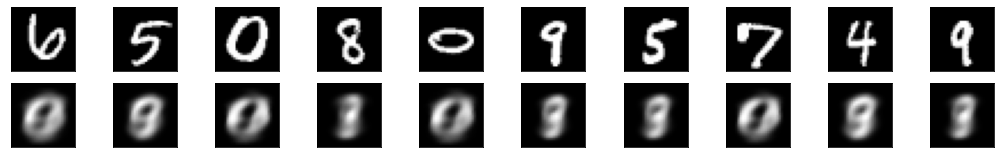

In [8]:
%matplotlib inline
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(X_test.shape[0], size=num_images)

encoded_imgs = shallow_encoder.predict(X_test)
decoded_imgs = shallow_ae.predict(X_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(X_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot reconstructed image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    print ("Random number pair ", i, "image ID: ", image_idx, encoded_imgs[image_idx])
plt.show()

We can use the `shallow_encoder` to see if these numbers are correct for a given sample:

In [9]:
latent_example = shallow_encoder.predict(X_test[860].reshape(1,784))
print(latent_example)

[[11.338859 26.439247]]


We can use the `shallow_decoder` to see if these number really reproduce the images seen above:

In [11]:
plt.figure()
## only works for latent_dim = 2!
def plot_dec(latent1=latent_example[0,0], latent2=latent_example[0,1]):
    plt.cla()
    
    # create a numpy array of certain shape
    latent_ex = np.array([latent1, latent2]).reshape(1,latent_dim)
    
    # let decoder predict the reconstructed image
    decoded_image = shallow_decoder.predict(latent_ex)
    
    # reshape prediction to get image
    decoded_image = decoded_image.reshape(28,28)
    
    # plot the image
    plt.imshow(decoded_image)
    
interact(plot_dec, latent1=((0.8)*latent_example[0,0], (1.2)*latent_example[0,0]), \
                   latent2=((0.8)*latent_example[0,1], (1.2)*latent_example[0,1]))

<Figure size 432x288 with 0 Axes>

interactive(children=(FloatSlider(value=11.338858604431152, description='latent1', max=13.606630325317383, min…

<function __main__.plot_dec(latent1=11.338859, latent2=26.439247)>

The shallow encoder doesn't really work. Let's try a 

### Deep Standard Autoencoder
Same setup in principle, we just need more layers. Implement a deep autoencoder in the following cell:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 784)               7056      
Total params: 13,434
Trainable params: 13,434
Non-trainable params: 0
____________________________________________________

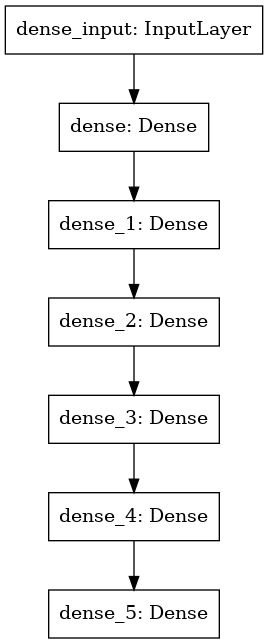

In [12]:
clear_session()

# begin by creating a sequential model called "deep_ae"
### BEGIN SOLUTION
deep_ae = Sequential()
### END SOLUTION

# next, define the encoder layers. Add a Dense layer with 8 neurons,
# appropriate input_shape and relu activation to deep_ae, then add
# another Dense layer with 4 neurons and relu activation, and finally
# add yet another Dense layer with latent_dim neurons and relu activation
### BEGIN SOLUTION
deep_ae.add(Dense(8, input_shape=(input_dim,), activation='relu'))
deep_ae.add(Dense(4, activation='relu'))
deep_ae.add(Dense(latent_dim, activation='relu'))
### END SOLUTION

# now we need the decoder layers. Add a Dense layer to deep_ae with
# 4 neurons and activation relu, then another Dense layer with 8
# neurons and activation relu, and finally another Dense layer
# with an appropriate number of neurons for creating images
# and sigmoid activation
### BEGIN SOLUTION
deep_ae.add(Dense(4, activation='relu'))
deep_ae.add(Dense(8, activation='relu'))
deep_ae.add(Dense(input_dim, activation='sigmoid'))
### END SOLUTION

# your model should have 13,434 trainable parameters
deep_ae.summary()
plot_model(deep_ae)

Let's also extract the encoder and decoder part like before, we just need more layers in each case:

In [16]:
input_img = Input(shape=(input_dim,))
input_lat = Input(shape=(latent_dim,))

encoder_layer1 = deep_ae.layers[0](input_img)
encoder_layer2 = deep_ae.layers[1](encoder_layer1)
encoder_layer3 = deep_ae.layers[2](encoder_layer2)
deep_encoder = Model(input_img, encoder_layer3)

decoder_layer1 = deep_ae.layers[-3](input_lat)
decoder_layer2 = deep_ae.layers[-2](decoder_layer1)
decoder_layer3 = deep_ae.layers[-1](decoder_layer2)
deep_decoder = Model(input_lat, decoder_layer3)

deep_encoder.summary()
deep_decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 6,326
Trainable params: 6,326
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
________________________________________

Next, we need to compile and train the model. Use the exact same setup as before, just change `shallow_ae` to `deep_ae`:

In [17]:
### BEGIN SOLUTION
deep_ae.compile(optimizer='adam', loss='binary_crossentropy')
deep_ae.fit(X_train, X_train,
                epochs=10,
                batch_size=256,
                validation_split=0.3)
### END SOLUTION

Epoch 1/10
154/154 [==============================] - 2s 10ms/step - loss: 0.5934 - val_loss: 0.2844
Epoch 2/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2802 - val_loss: 0.2701
Epoch 3/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2704 - val_loss: 0.2655
Epoch 4/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2668 - val_loss: 0.2623
Epoch 5/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2625 - val_loss: 0.2570
Epoch 6/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2568 - val_loss: 0.2530
Epoch 7/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2533 - val_loss: 0.2508
Epoch 8/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2510 - val_loss: 0.2493
Epoch 9/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2502 - val_loss: 0.2472
Epoch 10/10
154/154 [==============================] - 1s 8ms/step - loss: 0.2475 - val_loss: 0.244

As before, we can randomly sample 10 images and see what the deep autoencoder produces:

Random number pair  0 image ID:  7270 [0.       8.677055]
Random number pair  1 image ID:  860 [ 0.       30.731434]
Random number pair  2 image ID:  5390 [0.        7.4898167]
Random number pair  3 image ID:  13418 [ 0.      40.09503]
Random number pair  4 image ID:  5191 [0.       3.817987]
Random number pair  5 image ID:  11964 [ 0.      63.70889]
Random number pair  6 image ID:  11284 [ 0.       54.534973]
Random number pair  7 image ID:  5734 [0.       8.529485]
Random number pair  8 image ID:  6265 [ 0.      34.73751]
Random number pair  9 image ID:  466 [ 0.       63.485355]


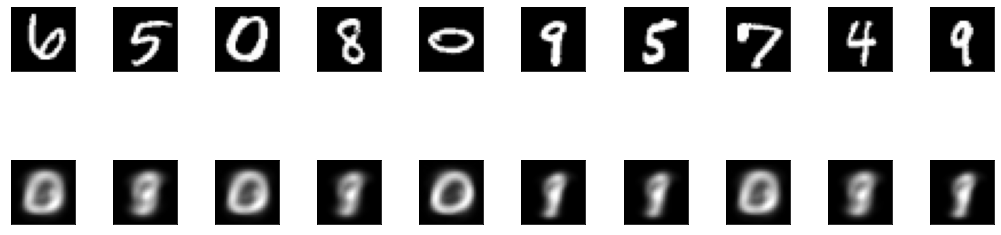

In [19]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(X_test.shape[0], size=num_images)

encoded_imgs = deep_encoder.predict(X_test)
decoded_imgs = deep_ae.predict(X_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(X_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    print ("Random number pair ", i, "image ID: ", image_idx, encoded_imgs[image_idx])
    
plt.show()

Check the encoding of one of the examples above again:

In [20]:
latent_example = deep_encoder.predict(X_test[860].reshape(1,784))
print(latent_example)

[[ 0.       30.731426]]


And let's explore the latent space a bit:

In [21]:
plt.figure()

def plot_dec(latent1=latent_example[0,0], latent2=latent_example[0,1]):
    plt.cla()
    
    # create a numpy array of certain shape
    latent_ex = np.array([latent1, latent2]).reshape(1,latent_dim)
    
    # let decoder predict the reconstructed image
    decoded_image = deep_decoder.predict(latent_ex)
    
    # reshape prediction to get image
    decoded_image = decoded_image.reshape(28,28)
    
    # plot the image
    plt.imshow(decoded_image)
    
interact(plot_dec, latent1=((0.8)*latent_example[0,0], (1.2)*latent_example[0,0]), \
                   latent2=((0.8)*latent_example[0,1], (1.2)*latent_example[0,1]))

<Figure size 432x288 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='latent1', max=0.0), FloatSlider(value=30.73142623901…

<function __main__.plot_dec(latent1=0.0, latent2=30.731426)>

The images created by adjacent latent vectors aren't related much. The quality here is quite bad, but it should be possible to see different numbers popping up for minute changes in the latent vector components.

---

## Convolutional Autoencoder (16  points)
Instead of using fully-connected layers, it's also possible to use convolutional layers for an autoencoder. The cell below will prepare everything that is needed. The training samples have to be reshaped to be matrices again, like the real images that constitute the data set. Since we're dealing with grayscale images, we only need to provide a single channel. The shape of the training data array thus has to be `(samples, 28, 28, 1)`. The input dimension for the first layer needs to be `(28, 28, 1)`.

In [24]:
%matplotlib inline
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

X = np.load("/data/X.npy") / 255

testsplit = int(0.8*X.shape[0])
X_train = X[:testsplit]
X_test  = X[testsplit:]

# CNNs expect matrices as input, so we have to reshape the training
# samples to matrices with 1 channel
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

print(X_train.shape)

input_dim = X_train.shape[1:]

(56000, 28, 28, 1)


Next, we need to setup a convolutional autoencoder. This is a bit more tedious, but in principle the same procedure as before. Instead of strided or transpose convolutions, we'll use simple upsampling here to increase the feature map sizes. Try out transpose convolutions and strided convolutions in your own experiments, they mostly yield better results.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 8)           0

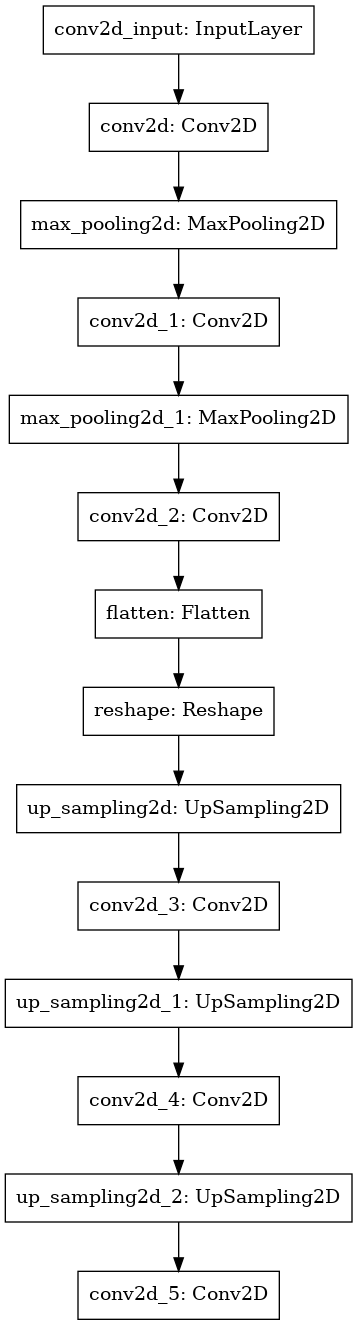

In [25]:
from tensorflow.keras.backend import clear_session

clear_session()

# begin by creating a sequential model called "conv_ae"
### BEGIN SOLUTION
conv_ae = Sequential()
### END SOLUTION


# start with the encoder layers. Add a "Conv2D" with 16 feature maps, a kernel size of
# (3, 3), 'relu' activation and "padding" set to "same". Set input_shape=input_dim.
# the next layeris a MaxPooling2D layer with kernel size (2,2) and padding set to "same".
# then follows another Conv2D layer with 8 feature maps, a kernel size of (3, 3), 
# 'relu' activation and padding set to 'same'.
# Again, add a MaxPooling2D layer with kernel size (2, 2) and padding set to 'same'.
# Then, add another Conv2D layer with 8 feature maps, a kernel size of (3, 3),
# strides set to (2, 2), relu activation and padding set to 'same'
### BEGIN SOLUTION
conv_ae.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_dim))
conv_ae.add(MaxPooling2D((2, 2), padding='same'))
conv_ae.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
conv_ae.add(MaxPooling2D((2, 2), padding='same'))
conv_ae.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))
### END SOLUTION

# Flatten encoding for visualization, this is the bottleneck
conv_ae.add(Flatten())
conv_ae.add(Reshape((4, 4, 8)))

# now the decoder part. Start by adding an "UpSampling2D" layer with kernel
# size (2, 2). Then, add a Conv2D layer with 8 feature maps and kernel size
# (3, 3), 'relu' activation and padding set to 'same'. Next, another 
# UpSampling2D layer is needed with kernel size (2, 2). The following layer
# is again Conv2D with 16 feature maps and a kernel size of (3, 3), as well
# as 'relu' activation. Then, another UpSampling2D layer with kernel size
# (2, 2) is needed. The last layer is again a Conv2D layer with a single
# feature map, kernel size of (3, 3), 'sigmoid' activation and padding set 
# to 'same'
### BEGIN SOLUTION
#conv_ae.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
conv_ae.add(UpSampling2D((2, 2)))
conv_ae.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
conv_ae.add(UpSampling2D((2, 2)))
conv_ae.add(Conv2D(16, (3, 3), activation='relu'))
conv_ae.add(UpSampling2D((2, 2)))
conv_ae.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
### END SOLUTION

# the model should have 3,801 trainable parameters
conv_ae.summary()
plot_model(conv_ae)

In [26]:
idxs = [0, 2, 4, 8, 10, 12]
weights = [(3, 3, 1, 16), \
           (3, 3, 16, 8), \
           (3, 3, 8, 8), \
           (3, 3, 8, 8), \
           (3, 3, 8, 16), \
           (3, 3, 16, 1)]
activations = [*5*["relu"], "sigmoid"]
for i,w in enumerate(idxs):
    if i > 0:
        assert "MaxPooling2D" in str(conv_ae.layers[w-1]) or "UpSampling2D" in str(conv_ae.layers[w-1])
    assert "Conv2D" in str(conv_ae.layers[w])
    assert conv_ae.layers[w].get_weights()[0].shape == weights[i]
    assert activations[i] in str(conv_ae.layers[w].activation)

Now we only need to compile and train the model like before. Use the same setup as in the standard autoencoder case, but change the `epochs` to 5 to save some time. This should be more than enough to get good results. You can even see good results with only 2 `epochs`. This will take much longer than before.

In [27]:
### BEGIN SOLUTION
conv_ae.compile(optimizer='adam', loss='binary_crossentropy')
conv_ae.fit(X_train, X_train,
                epochs=2,
                batch_size=256,
                validation_split=0.3)
### END SOLUTION

Epoch 1/2
154/154 [==============================] - 18s 112ms/step - loss: 0.4113 - val_loss: 0.1681
Epoch 2/2
154/154 [==============================] - 12s 78ms/step - loss: 0.1587 - val_loss: 0.1419


Again, we can print 10 examples from the test set and compare them to the autoencoded results.

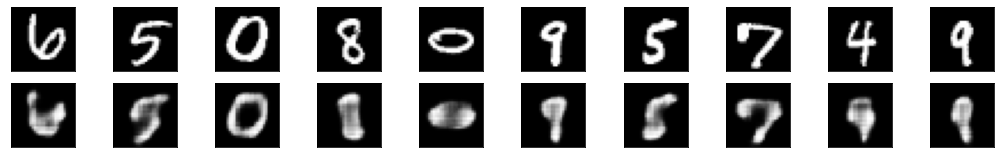

In [30]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(X_test.shape[0], size=num_images)

#encoded_imgs = encoder.predict(x_test)
decoded_imgs = conv_ae.predict(X_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(X_test[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # plot reconstructed image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

This should work much better than the fully-connected autoencoders with the same size of the bottleneck layer. The bottleneck layer here has 128 neurons, so we compressed the information saved in a vector of size 784 into a vector of size 128. 

When using linear activation functions, autoencoders produce exactly the same subspace found by **PCA**. The advantage here is that we can easily create nonlinear versions of autoencoders by using nonlinear activation functions. They work much better and are computationally less expensive (once trained) on extremely high-dimensional datasets than PCA. Companies like Amazon reduce their gigantic data space by using autoencoders to encode the millions of features they're collecting into a ~50-dimensional space. Then, they use `t-sne` to further reduce dimensionality and to uncover hidden connections in the data. The result can be plotted in 2D or 3D. 

---

## Generative Adversarial Networks (14 points)
GANs directly sample from the underlying distribution instead of modeling it. They are difficult to train and usually large, so we'll have to do with a smaller model here. Still, the training will take quite a while.

The next code cell will setup everything we need.

In [42]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, AlphaDropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model

from IPython.display import clear_output

#print(2**13)
X_train = np.load("/data/X.npy")[:8192] / 255

Instead of writing models directly, it is often useful to write a function instead that creates a model. The function skeleton is provided below. Fill in the gaps to make it return a generator network.

In [33]:
def create_generator(activation, input_dim):
    # create a Sequential() model below called "generator". Add a Dense() layer with
    # 256 neurons, input_dim and activation according to the function arguments.
    # Then, add an "AlphaDroupout" layer with rate 0.3.
    # Add yet another Dense() layer with 512 units and activation according to the
    # function argument. Add another AlphaDropout layer with the same rate. Add a 
    # last Dense() layer with 784 neurons and "tanh" activation. 
    # Finally, compile your model with an appropriate loss function (what kind of image
    # are we processing here? What are the pixel values?) and optimizer "adam".
    ### BEGIN SOLUTION
    generator = Sequential()

    generator.add(Dense(units = 256,  input_dim = input_dim, activation=activation))
    generator.add(AlphaDropout(0.3))
    generator.add(Dense(units = 512, activation=activation))
    generator.add(AlphaDropout(0.3))
    generator.add(Dense(units = 784,  activation = "tanh"))

    generator.compile(loss = "binary_crossentropy", optimizer = "adam")
    ### END SOLUTION

    return generator

This will give us a generator network, where we can adjust the activation function for testing different setups. Next, we'll need a discriminator network:

In [35]:
def create_discriminator(activation):
    # here, we need pretty much the opposite of the generator. Create a Sequential() 
    # model and add a Dense() layer with 512 neurons and input_dim 784, activation set 
    # to the function argument. Then, add an AlphaDropout() layer with dropout rate
    # 0.3. Add another Dense() layer with 256 neurons and activation according to the
    # function argument. Add another AlphaDropout() layer. The last Dense() layer now
    # should consist of a single neuron and "sigmoid" activation (why?).
    # Finally, compile the model with an appropriate loss function and the "adam"
    # optimizer.
    ### BEGIN SOLUTION
    discriminator = Sequential()

    discriminator.add(Dense(units = 512, input_dim = 784, activation=activation))
    discriminator.add(AlphaDropout(0.3))
    discriminator.add(Dense(units = 256, activation=activation))
    discriminator.add(AlphaDropout(0.3))
    discriminator.add(Dense(units = 1, activation = "sigmoid"))

    discriminator.compile(loss = "binary_crossentropy", optimizer = "adam")
    ### END SOLUTION

    return discriminator

To create the actual GAN, another function makes sense that takes a generator and a discriminator as input and creates the full network. In the cell below, you only need to compile the "gan" with an appropriate `loss` function and the `adam` optimizer.

In [37]:
def create_gan(generator, discriminator, input_dim):
    # set the discriminator to "untrainable" first
    discriminator.trainable = False
    # create an input layer for the gan
    gan_input = Input(shape=(input_dim,))
    # add input layer to the generator 
    gen_part = generator(gan_input)
    # add the discriminator to the generator part
    gan_output = discriminator(gen_part)
    # create the actual GAN model
    gan = Model(inputs = gan_input, outputs = gan_output)

    # compile the model with an appropriate loss function and 'adam' optimizer
    ### BEGIN SOLUTION
    gan.compile(loss = "binary_crossentropy", optimizer = "adam")
    ### END SOLUTION

    return gan

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               536592    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 533505    
Total params: 1,070,097
Trainable params: 536,592
Non-trainable params: 533,505
_________________________________________________________________


The `save_images` helper function below saves generated images during the training later.

In [43]:
def save_images(epoch, generator, input_dim, dim = [5, 5]):
    # how many images to generate
    examples = dim[0]*dim[1]
    # create noise vector
    noise = np.random.uniform(-1, 1, size = [examples, input_dim])
    # generate adversarial samples and reshape to image
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    clear_output(wait=True)
    
    # plot images during training
    plt.figure(figsize=(10, 10))
    
    plt.suptitle(f"Epoch {epoch}", fontsize=16)
    
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation = "nearest", cmap='viridis')
        plt.axis("off")
        
    plt.tight_layout()
    # save the images for later processing
    plt.savefig("gan_preds_" + str(epoch).zfill(2) + ".png")
    plt.show()

Now all that is left is the training itself. The following function generalizes a few things about the training process.

In [40]:
def train(X_train, input_dim, activation, epochs, batch_number):
    # determine batch_size from number of batches desired
    batch_size = X_train.shape[0] // batch_number

    # generate the models
    generator = create_generator(activation, input_dim)
    discriminator = create_discriminator(activation)
    gan = create_gan(generator, discriminator, input_dim)
    
    # print summaries and model graphs
    print("############   Generator   ############")
    generator.summary()
    print("\n\n")
    print("############ Discriminator ############")
    discriminator.summary()
    print("\n\n")
    print("############      GAN      ############")
    gan.summary()
    print("\n\n")
    #plot_model(generator)

    # loop over epochs
    for epoch in range(0, epochs):
        print("\nEpoch ", epoch)
        # loop over batches in each epoch
        for batch in range(batch_number):
            print("\rBatch ", batch, "/ ", batch_number, end="", flush=True)
            # the discriminator needs a few more training rounds each time,
            # otherwise it stays too weak
            for d in range(3):
                # generate batch_size noise vectors
                noise = np.random.uniform(-1, 1, [batch_size, input_dim])
                # generate adversarial samples on all noise vectors
                generated_images = generator.predict(noise)
                # get a batch of real images
                image_batch = X_train[np.random.randint(low = 0, high = X_train.shape[0], size = batch_size)]
                # concatenate both batches to create the input for the discriminator
                X = np.concatenate([image_batch, generated_images])
                # label the fake images as 0 and the real ones as 0.9
                # this is a trick to avoid saturation of the tanh activation
                y_dis = np.zeros(2*batch_size)
                y_dis[:batch_size] = 0.9
        
                # set discriminator to trainable
                discriminator.trainable = True
                # and train it on the batches of fake and real samples
                discriminator.train_on_batch(X, y_dis)
                # set discriminator weights to untrainable again
                discriminator.trainable = False
        
            # create the training samples for the generator
            noise = np.random.uniform(-1, 1, [batch_size, input_dim])
            y_gen = np.ones(batch_size)
        
            gan.train_on_batch(noise, y_gen)
    
        # plot and save some predictions each 5 epochs
        if epoch % 5 == 0:
            save_images(epoch, generator, input_dim, [5, 5])

Run the following cell to start the training. You can play around with the parameters to see how e.g. different activation functions change the training progress, or whether a smaller or larger noise vector changes anything.

This will take a very long time (check out some [AI-generated music](https://www.youtube.com/results?search_query=ai+generated+music) in the meantime or use the [openAI Jukebox](https://openai.com/blog/jukebox/) to create your own).

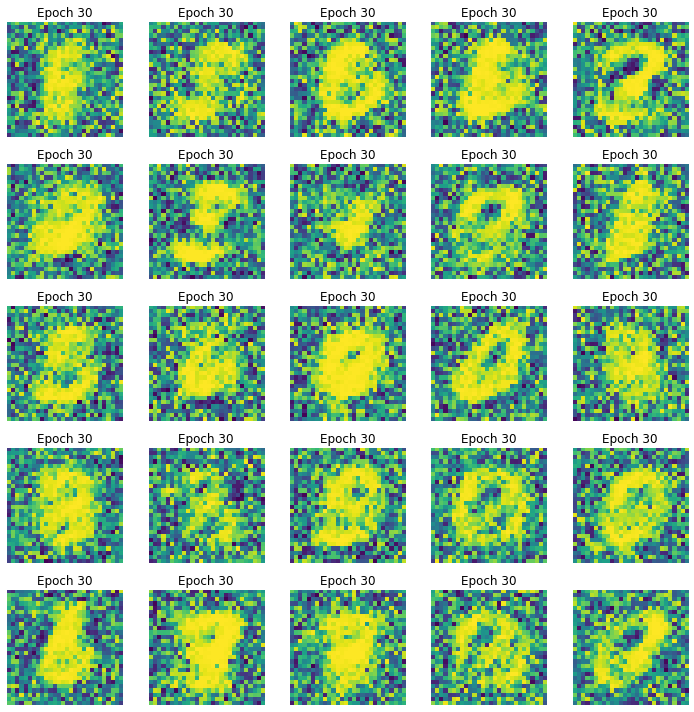

In [44]:
%matplotlib inline
from tensorflow.keras.backend import clear_session

clear_session()

train(X_train, 100, 'selu', 31, 32)

You should be able to see some progress in the second image at epoch 5, where the generator learns that the center section is more important and again in the third image at epoch 10, when some outlines start to form. In the last images you can see that these outlines become slightly fine-tuned, with empty areas around them starting to form. This will become better and better with increasing number of epochs. To get some good results, a few hundred epochs are necessary and perhaps a lower number of batches.

The images are saved as `.png` files, which can be converted to a `.gif`:

In [47]:
from PIL import Image
from glob import glob

images = sorted(glob("gan_preds*.png"))
frames = [Image.open(image) for image in images]

frames[0].save('gan_training.gif', format='GIF', append_images=frames[1:], save_all=True, duration=1000, loop=0)

You should be able to see a progression in the following gif animation, if everything worked as expected. If you create a new image, your browser will probably cache the old animation and you won't see the changed image. In that case, double-click this cell to edit it, then attach a "?" after the filename, such that it reads `"gan_training.gif?xxx"`. Insert a random number instead of `xxx`, that will trick the browser cache into reloading the image. 

<div>
<img src="gan_training.gif?3" width="700" align="middle" style="margin:50px 50px"/>
</div>

This whole process takes a LOT of time unfortunately. There is something that cannot be shown in such a short time unfortunately, which is the phenomenon of **mode collapse**. In training with a slightly larger GAN than the one above and using $\text{ReLU}$ activations, the following image was generated over 400 epochs:

<div>
<img src="gan_relu.png" width="700" align="middle" style="margin:50px 50px"/>
</div>

while the same GAN trained with $\text{selu}$ activation generated the following images after 400 epochs:

<div>
<img src="gan_selu.png" width="700" align="middle" style="margin:50px 50px"/>
</div>

The difference is that the GAN is extremely confident in the results using the $\text{selu}$ activation, and at some point starts to only produce 0s and 1s. This is essentially a *zero mode* in the solution. Recall that we're trying to optimize a cost function here. In finite element analysis, that cost function is the global potential. Under certain circumstances, this global potential can allow zero modes, which are solutions that do not change the potential at all (they do not cost any energy), but produce movement/deformations. Examples for this are locking and hourglassing. A similar thing happens here. The network learns a "lazy" solution that fulfills the requirement in a satisfying way regarding the optimization goal, but it's not the solution we were looking for. 

A great example for such a mode collapse can be seen in the beginning of [this video](https://www.youtube.com/watch?v=GdTBqBnqhaQ) from 2minutepapers (a generally recommendable channel on cutting edge AI research!). Here, researchers tried to let a neural network learn a movement pattern for a spider robot that minimizes leg contact with the ground while moving from a predefined position A to a destination B. The surprising result after many training iterations was that this was possible without any leg-to-ground contact at all. The robot simply "learned" to flip over and walk on its "elbows".

This is not necessarily a bug or undesired feature of neural networks. Sometimes, this can lead to solutions which us humans would have never thought about in the first place, especially regarding generative design. In other situations, this is completely undesired. It's important to keep your objective (as in objective function) in mind, when designing machine learning solution algorithms.

---